In [1]:

import numpy as np
from pymc3 import Model, Bernoulli, Normal, find_MAP
import theano.tensor as tt
import theano.sparse as sprs
from scipy.sparse import lil_matrix

In [2]:


def _create_order_projection_tensor(ddx_max_length, ddx_extended):
    num_dxs = len(ddx_extended)
    assert ddx_max_length <= num_dxs, "ddx_max_length: %d, num_dxs: %d"%(ddx_max_length,num_dxs)
    reord_proj_tensor = np.zeros([num_dxs,ddx_max_length])
    for i in range(ddx_max_length):
        reord_proj_tensor[ddx_extended[i],i] +=1
    return reord_proj_tensor

In [3]:
def _low_mem_graphical_model(order_indicator_array_data,
                             reord_proj_tensor_data,
                             findings_indicator_data,
                             bias=0.,
                             hidden_var_prior_deviation=10.,
                             param_matrix_prior_deviation=10.,
                             weight_matrix=None):
    """
    Builds the graphical model and ties the observable variables to the data. You can pass a batch of 
    :class:`int` `size` data; with :class:`int` `num_dxs` possible diagnoses, :class:`int` `num_findings`
    possible findings, and :class:`int` `ddx_max_length` maximum diagnoses in a given differential.

    Parameters:
        order_indicator_array_data (:class:`np.array`): should be of shape 
            [`ddx_length`,`num_dxs`].
        reord_proj_tensor_data (:class:`np.array`): should be of shape 
            [`num_dxs`,`num_dxs`].
        findings_indicator_data (:class:`np.array`): the findings i

    Returns:
        4-:tuple: containing (x, dx_order, W, findings), where
            hidden_vars (:class:`Normal`): are hidden variables
            dx_order_rv (:class:`Bernoulli`): indicate the order of diagnoses in the differential
            weight_matrix_rv (:class:`Normal`): is a matrix of parameters relating diagnoses to findings
            findings_rv (:class:`Bernoulli`): indicate the presence of findings

    """

    # sigmoid function
    def invlogit(x):
        return 1. / (1 + tt.exp(-x))

    ddx_length, num_dxs = order_indicator_array_data.shape
    num_findings = len(findings_indicator_data)

    hidden_vars = Normal('hidden_vars', mu=0., sd=hidden_var_prior_deviation, shape=num_dxs)
    if (ddx_length > 1):
        dx_order_s_1 = tt.tensordot(hidden_vars, reord_proj_tensor_data, axes=[0, 0])
        dx_order_s_1 = tt.reshape(dx_order_s_1, [ddx_length, 1])
        dx_order_s_2 = tt.reshape(hidden_vars, [1, num_dxs])
        dx_order_p = invlogit(tt.tile(dx_order_s_1, [1, num_dxs]) - tt.tile(dx_order_s_2, [ddx_length, 1]))
        dx_order_rv = Bernoulli("order", p=dx_order_p, observed=order_indicator_array_data)
    else:
        dx_order_rv = None
    dx_extra = Bernoulli("seen", p=invlogit(hidden_vars), observed=1.)

    if weight_matrix is None:
        weight_matrix_rv = Normal('weight_matrix', mu=0, sd=param_matrix_prior_deviation, shape=[num_dxs, num_findings])
    else:
        weight_matrix_rv = weight_matrix

    findings_p = invlogit(tt.tensordot(hidden_vars, weight_matrix_rv, axes=[0, 0]) + bias)
    findings_rv = Bernoulli("findings", findings_p, observed=findings_indicator_data)

    return (hidden_vars, dx_order_rv, weight_matrix_rv, findings_rv)


In [4]:
total_num_dxs = 5000
total_num_findings = 20000
ddx_max_length = 10
hidden_var_prior_deviation= 10. #gen_logistic_low_mem_args.hidden_var_prior_deviation
param_matrix_prior_deviation= 10. #gen_logistic_low_mem_args.param_matrix_prior_deviation
#verbose=gen_logistic_low_mem_args.verbose
bias = 0.

In [5]:
weight_matrix = np.random.randn(total_num_dxs, total_num_findings)

In [27]:
ddx, findings = [1,5,6],[5,7,8,3]

from itertools import ifilterfalse

ddx_extended = ddx + list(ifilterfalse(ddx.__contains__, range(total_num_dxs)))

order_projection_tensor = _create_order_projection_tensor(len(ddx), ddx_extended)

order_indicator_array = np.ma.ones([len(ddx), total_num_dxs])
for i in range(0,len(ddx)):
    for j in range(i):
        order_indicator_array[i,ddx[j]] = 0
    order_indicator_array[i,ddx[i]] = np.ma.masked

findings_hot_unmasked = np.zeros(total_num_findings, dtype=np.int)
findings_hot_unmasked[findings] = 1
findings_hot = np.ma.masked_equal(findings_hot_unmasked, value=0)


In [33]:
order_indicator_array.shape

(3, 5000)

In [36]:
import datetime
start_map = datetime.datetime.now()

In [37]:
num_ddx_to_consider = 100
approx_hidden = np.sum(weight_matrix[:,findings],axis = 1)
from heapq import nlargest
ddx_to_consider = nlargest(num_ddx_to_consider, range(len(approx_hidden)), key=lambda i: approx_hidden[i])
ddx_to_consider = sorted(ddx_to_consider)

In [38]:

with Model() as gen_logistic_model:
    _low_mem_graphical_model(order_indicator_array[:,ddx_to_consider],
                             order_projection_tensor[ddx_to_consider,:],
                             np.ones(len(findings)),
                             bias,
                             hidden_var_prior_deviation,
                             param_matrix_prior_deviation,
                             weight_matrix[np.array(ddx_to_consider)[:,np.newaxis],findings])


In [39]:

map_estimate = find_MAP(model=gen_logistic_model)
end_map = datetime.datetime.now()

Optimization terminated successfully.
         Current function value: 600.750768
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16


In [10]:


from heapq import nlargest
ddx_new = nlargest(ddx_max_length, range(total_num_dxs), key=lambda i: map_estimate['hidden_vars'][i])
findings_new_hot = np.dot(map_estimate['hidden_vars'],weight_matrix)>0
findings_new = [i for i in range(total_num_findings) if findings_new_hot[i]]


In [11]:
findings_new

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 13,
 16,
 18,
 20,
 22,
 24,
 25,
 26,
 30,
 31,
 33,
 36,
 37,
 38,
 39,
 41,
 44,
 46,
 48,
 50,
 51,
 54,
 55,
 57,
 59,
 61,
 62,
 63,
 66,
 71,
 72,
 74,
 76,
 79,
 81,
 82,
 85,
 86,
 87,
 88,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 103,
 104,
 105,
 107,
 109,
 110,
 114,
 115,
 116,
 119,
 121,
 124,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 136,
 138,
 139,
 140,
 142,
 144,
 147,
 148,
 150,
 151,
 153,
 154,
 157,
 158,
 163,
 164,
 165,
 166,
 171,
 172,
 173,
 174,
 176,
 177,
 179,
 183,
 184,
 185,
 190,
 193,
 199,
 201,
 203,
 204,
 206,
 210,
 213,
 215,
 219,
 220,
 221,
 222,
 223,
 226,
 228,
 231,
 233,
 235,
 236,
 238,
 240,
 241,
 245,
 246,
 251,
 253,
 255,
 256,
 257,
 258,
 259,
 262,
 266,
 275,
 277,
 278,
 282,
 284,
 287,
 288,
 289,
 290,
 293,
 295,
 296,
 297,
 298,
 299,
 300,
 303,
 306,
 307,
 309,
 311,
 315,
 317,
 318,
 319,
 320,
 321,
 324,
 325,
 326,
 331,
 332,
 334,
 337,
 341,
 343,
 345,
 349,

In [12]:
ddx_new

[1, 5, 6, 3707, 877, 2538, 3591, 3231, 658, 4101]

In [42]:
from pymc3 import sample

In [43]:
start_sample = datetime.datetime.now()
with gen_logistic_model:
    trace = sample(1000)
end_sample = datetime.datetime.now()


Assigned NUTS to hidden_vars
Assigned BinaryGibbsMetropolis to order_missing

 16%|█▌        | 157/1000 [00:07<00:33, 24.92it/s]

100%|██████████| 1000/1000 [00:23<00:00, 42.48it/s]

In [46]:
print(end_map-start_map)
print(end_sample-start_sample)

0:00:09.360741
0:00:39.955333


In [41]:
ddx_new

[1, 5, 6, 3707, 877, 2538, 3591, 3231, 658, 4101]

In [56]:
import matplotlib
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x151c3cb50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x151e49050>]], dtype=object)

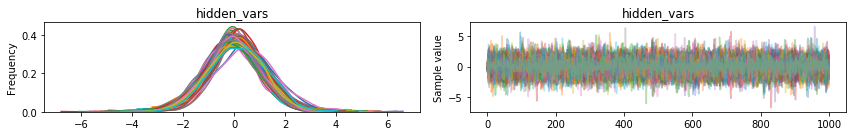

In [58]:
from pymc3 import traceplot, summary
traceplot(trace,['hidden_vars'])

In [59]:
summary(trace)


hidden_vars:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.012            1.185            0.029            [-2.200, 2.361]
  -0.125           1.104            0.032            [-2.132, 2.227]
  -0.075           1.157            0.036            [-2.150, 2.254]
  -0.163           1.080            0.031            [-2.372, 1.872]
  0.101            1.120            0.038            [-2.126, 2.533]
  0.265            1.118            0.033            [-2.099, 2.317]
  0.156            1.052            0.030            [-2.097, 2.091]
  -0.204           1.040            0.033            [-2.356, 1.784]
  -0.096           1.108            0.029            [-2.235, 2.174]
  0.045            1.053            0.034            [-2.013, 2.115]
  -0.112           1.183            0.033            [-2.493, 1.985]
  -0.058           1.227            0.031            [-2.685, 2.242]
  0.189       